In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np
import sys, pickle, os, torch, cv2
# replace this path with path to GMIC
#sys.path.append("/path/to/GMIC")

from src.data_loading import loading
from src.modeling import gmic as gmic

### You need to obtain the cropped images (bash run.sh) before using this demo.

Step 1: prepare the input data

In [2]:
with open("sample_output/data.pkl", "rb") as f:
    exam_list = pickle.load(f)
datum = exam_list[3]
view = "L-CC"
short_file_path = datum[view][0]

Step 2: load the image

In [3]:
loaded_image = loading.load_image(
                    image_path=os.path.join("sample_output/cropped_images/", short_file_path + ".png"),
                    view=view, horizontal_flip=datum["horizontal_flip"])

Step 3: preprocess the image

In [4]:
loaded_image = loading.process_image(loaded_image, view, datum["best_center"][view][0])

Let's visualize a sample image

(2944, 1920)


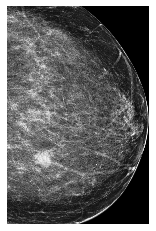

In [5]:
print(loaded_image.shape)
plt.imshow(loaded_image, cmap="Greys_r")
plt.axis("off")
plt.show()

Step 4: load the model

In [6]:
parameters = {
        "device_type":"cpu",
        "cam_size": (46, 30),
        "K": 6,
        "crop_shape": (256, 256),
        "percent_t":0.02
        "post_processing_dim": 256,
        "num_classes": 2
    }

In [7]:
model = gmic.GMIC(parameters)

In [8]:
model.load_state_dict(torch.load("models/sample_model_1.p", map_location="cpu"), strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['shared_rep_filter.weight'])

Step 5: inference

In [9]:
tensor_batch = torch.Tensor(np.expand_dims(np.expand_dims(loaded_image, 0), 0).copy())
output = model(tensor_batch)
pred_numpy = output.data.cpu().numpy()
malignant_pred = pred_numpy[0, 1]

In [10]:
print("malignant prediction = {}".format(malignant_pred))

malignant prediction = 0.2067277729511261


Step 6: visualize the saliency map

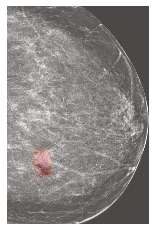

In [11]:
saliency_maps = model.saliency_map.data.cpu().numpy()
malignant_saliency_map = saliency_maps[0,1,:,:]
alphas = np.abs(np.linspace(0, 0.95, 259))
alpha_red = plt.cm.get_cmap('Reds')
plt.figure()
plt.imshow(loaded_image, cmap="Greys_r")
plt.imshow(cv2.resize(malignant_saliency_map, (1920, 2944)), alpha=0.3, cmap=alpha_red, clim=[0.0, 1.0])
plt.axis("off")
plt.show()